In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b3d
import bayes3d.genjax
import genjax
from genjax import gen
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import jax.tree_util as jtu
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import Diff
import trimesh
import pythreejs as p3s
# console = genjax.pretty(show_locals=False)
key = jax.random.PRNGKey(0)

def more_keys(key, n=1):
    keys = jax.random.split(key,n)
    if n == 1: return keys[0]
    return keys

def rot2d(hd): return jnp.array([
    [jnp.cos(hd), -jnp.sin(hd)], 
    [jnp.sin(hd),  jnp.cos(hd)]
    ])
def pack_2dpose(x,hd): return jnp.concatenate([x,jnp.array([hd])])

In [62]:
# 
# Monkey patching `sample` for `BuiltinGenerativeFunction`
# 
cls = genjax._src.generative_functions.builtin.builtin_gen_fn.BuiltinGenerativeFunction

def genjax_sample(self, key, *args, **kwargs):
    _, tr = self.simulate(key, args)
    return tr.get_retval()

setattr(cls, "sample", genjax_sample)


# 
# Monkey patching `sample` for `DeferredGenerativeFunctionCall`
# 
cls = genjax._src.generative_functions.builtin.builtin_gen_fn.DeferredGenerativeFunctionCall

def deff_gen_func_call(self, key, **kwargs):
    return self.gen_fn.sample(key, *self.args, **kwargs)

def deff_gen_func_logpdf(self, x, **kwargs):
    return self.gen_fn.logpdf(x, *self.args, **kwargs)

setattr(cls, "__call__", deff_gen_func_call)
setattr(cls, "logpdf", deff_gen_func_logpdf)

In [8]:
from bayes3d._mkl.pose import pack_pose, unpack_pose, apply_pose, lift_pose, from_euler, look_at
from bayes3d._mkl.meshes import *
from bayes3d._mkl.plotting import *
from bayes3d._mkl.raycast import cast, jcast, create_angles
import numpy as np


fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T = len(_xs)

_bb = jnp.array([
    [jnp.min(_segs[...,0]), jnp.min(_segs[...,1])],
    [jnp.max(_segs[...,0]), jnp.max(_segs[...,1])]
])


_ps = np.concatenate([_xs, _hds[:,None]], axis=1)
_ps3d = jax.vmap(lift_pose)(_xs, _hds)

_boxes[0], _T

(array([ 7.1517381 , 17.62209524,  7.8517381 , 17.62209524]), 50)

In [9]:
box_mesh = trimesh.util.concatenate([trimesh_from_2d_segs(box) for box in _boxes.reshape(-1,4,4)])
map_mesh = trimesh_from_2d_segs(_segs)
table = create_cuboid(20, 20, -0.1)
table = move_to_xy(table, *_center)

map_mesh.vertices[:,2] -= 0.5
box_mesh.vertices[:,2] -= 0.5
table.vertices[:,2] -= 0.5

In [5]:
v = Viewer(cam_pos=(*_center,15), cam_look=np.array([*_center,0]), background="#eee", view_as="world")
v.add_mesh(map_mesh.vertices, map_mesh.faces, c=np.array([.99,.99,.99]))
v.add_mesh(box_mesh.vertices, box_mesh.faces, c=np.array([.99,.1,.1]))
v.add_mesh(table.vertices, table.faces, c=np.array([1.,1.,1.]))
for p in _ps3d: v.add_pose(p, scale=0.5, width=2)

v

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.6, positio…

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 64, 1024)
['object_0', 'object_1']
(50, 100, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


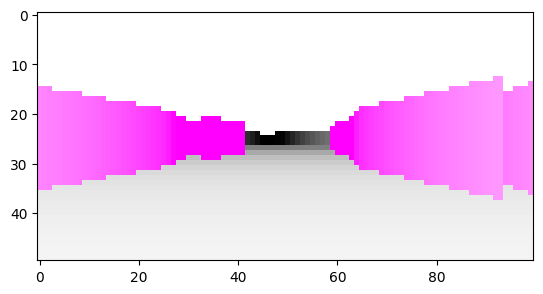

In [6]:
h = 50
w = 100

intrinsics = b3d.Intrinsics(
    height=h,
    width=w,
    fx=10.0, fy=10.0,
    cx=w/2, cy=h/2,
    near=0.01, far=20.0
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([map_mesh, table]), center_mesh=False)
b3d.RENDERER.add_mesh(box_mesh, center_mesh=False)

def render(p):
    p_ = b3d.t3d.inverse_pose(p)
    return b3d.RENDERER.render(jnp.tile(p_, (2,1,1)), jnp.array([0,1]))

print(b3d.RENDERER.mesh_names)

t = 40
p = _ps3d[t]
x,r = unpack_pose(p)

img = render(p)
print(img.shape)




im = np.zeros((h,w,3))
im[jnp.isclose(img[:,:,3],1)] = 1- np.array([0.8,0.8,0.8])
im[jnp.isclose(img[:,:,3],2)] = 1-np.array([1,0,1])

# -----------------
plt.imshow(1-im*img[:,:,[2]])

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 32, 1024)
['object_0', 'object_1']
(1, 100, 4)
(100, 2)


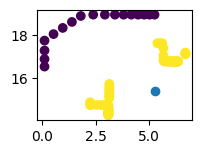

In [12]:
h = 1
w = 100

intrinsics = b3d.Intrinsics(
    height=h,
    width=w,
    fx=10.0, fy=1.0,
    cx=w/2, cy=0.0,
    near=0.01, far=20.0
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([map_mesh, table]), center_mesh=False)
b3d.RENDERER.add_mesh(box_mesh, center_mesh=False)

def render(p):
    p_ = b3d.t3d.inverse_pose(p)
    return b3d.RENDERER.render(jnp.tile(p_, (2,1,1)), jnp.array([0,1]))

print(b3d.RENDERER.mesh_names)

t = 40
p = _ps3d[t]


img = render(p)
print(img.shape)

xs = img[0,:,[0,2]].T
print(xs.shape)

def apply_2dpose(p, ys): 
    return ys@rot2d(p[2] - jnp.pi/2).T + p[:2]

xs = apply_2dpose(_ps[t], xs)



# -----------------
plt.figure(figsize=(2,2))
plt.gca().set_aspect(1)
plt.scatter(*_ps[t][:2], marker="o")
plt.scatter(*xs.T,c=img[0,:,3])

In [13]:
from genjax.generative_functions.distributions import ExactDensity
from bayes3d._mkl.likelihood import constrained_lh, constrained_lh_jit, pad_jit
from bayes3d.likelihood import threedp3_likelihood
from functools import partial 
from jax import jit

from genjax import (
    tfp_uniform as uniform,
    choice_map,
)


def make_likelihood(w, zmax):
    class B3DImageDist(ExactDensity):
        def sample(self, key, Y, sig, outlier):
            # TODO: write this method
            return Y

        def logpdf(self, X, Y, sig, outlier):
            return constrained_lh(X, Y, zmax, sig, outlier, w)
        
    return B3DImageDist()
    


zmax    = 20.0
sig     = 0.5
outlier = 0.1
w       = 5

In [14]:

def make_model(w, zmax):

    b3d_img_dist = make_likelihood(w, zmax)

    @gen
    def model():

        x  = uniform(jnp.array([-20.,-20.]), jnp.array([20.,20.])) @ "x"
        hd = uniform(-jnp.pi, jnp.pi) @ "hd"
        
        # Lift pose to 3D and 
        # render an image
        Y = render(lift_pose(x,hd))

        sig     = uniform(0.0001, 0.1) @ "sig"
        outlier = uniform(0.0001, 0.1) @ "outlier"

        X = b3d_img_dist(Y, sig, outlier) @ "image"

        return pack_2dpose(x, hd), X[0,:,[0,2]].T
    
    return model


In [15]:
t = 40

model = make_model(w, zmax)
ch = genjax.choice_map(dict(x=_xs[t], hd=_hds[t]))
model_args = ()

key,(_,tr) = model.importance(key, ch, model_args)

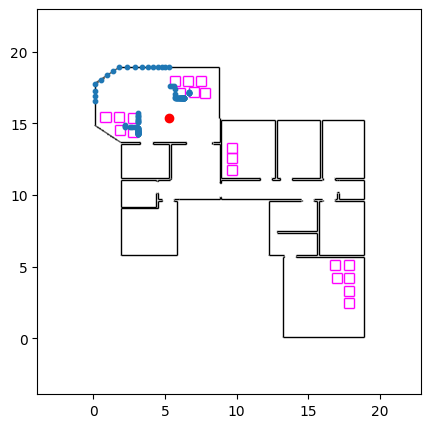

In [16]:
p, xs = tr.get_retval()

_segs  = _segs.reshape(-1,2,2)
_boxes = _boxes.reshape(-1,2,2)
padding = 4

# ---------------------
plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.xlim(np.min(_segs[:,:,0])-padding, np.max(_segs[:,:,0])+padding)
plt.ylim(np.min(_segs[:,:,1])-padding, np.max(_segs[:,:,1])+padding)
plt.gca().add_collection(line_collection(_segs[:,0],_segs[:,1], c="k", zorder=1))
plt.gca().add_collection(line_collection(_boxes[:,0],_boxes[:,1], c="magenta", zorder=1))
plt.scatter(*p[:2], c="r", zorder=2)
plt.scatter(*apply_2dpose(p, xs).T, s=10, zorder=2)

In [17]:
key = more_keys(key)
ch = choice_map({
        "x":  _xs[0],
        "hd": _hds[0],
        "sig": 0.1,
        "outlier": 0.1,
})

key, (w,tr) = model.importance(key, ch, ())
w

Array(-4.608465, dtype=float32)

In [27]:
def _eval_pose(trace, key, p):
    ch    = choice_map({'x':p[:2], 'hd':p[2]})
    diffs = tuple(map(lambda v: Diff(v, UnknownChange), trace.args))

    return trace.update(key, ch, diffs)[1][2].get_score()

eval_poses = jax.jit(jax.vmap(_eval_pose, in_axes=(None, None, 0)))

In [28]:
key, = jax.random.split(key, 1)
ps = np.random.randn(20_000, 3)
%timeit -n 1 -r 1 eval_poses(tr, key, ps).block_until_ready()

2.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [29]:
def vector_grid(v0, shape, r, flat=False):
    r = jnp.array(r)
    vs = np.stack(jnp.indices(shape), axis=-1).reshape(-1,len(shape))
    vs = r[None]*vs
    center = (vs[0] + vs[-1])/2
    vs = vs - center + v0
    if flat: 
        return vs
    else: 
        return vs.reshape(shape)


In [56]:
genjax.tfp_normal.sample(key, jnp.zeros(2), 0.01*jnp.ones(2))

Array([-0.0078092 ,  0.00182073], dtype=float32)

In [72]:
@gen
def anchored_pose_prior(p, sig_x=0.5, sig_hd=10):
    sig_hd = sig_hd/180*jnp.pi
    x  = genjax.tfp_normal(p[:2], sig_x*jnp.ones(2)) @ "x"
    hd = genjax.tfp_normal(p[2], sig_hd) @ "hd"
    return pack_2dpose(x, hd)


In [ ]:
def unit_vec(hd): return jnp.array([jnp.cos(hd), jnp.sin(hd)])


@gen
def grid_proposal(tr, key, p0, shape, res):

    # Score each pose in the grid
    vs = vector_grid(p0, shape, res, flat=True)
    sc = eval_poses(tr, key, vs)
    sc = sc - jax.scipy.special.logsumexp(sc)

    # Sample from the discretized grid scores
    i = genjax.tfp_categorical(sc) @ "i"
    v = vs[i]

    # Pose 
    x  = uniform(v[:2] - r[:2]/2, v[:2] + r[:2]/2) @ "x"
    hd = uniform(v[2] - r[2]/2, v[2] + r[2]/2) @ "hd"

    return pack_2dpose(x,hd)


TypeError: 'DeferredGenerativeFunctionCall' object is not subscriptable

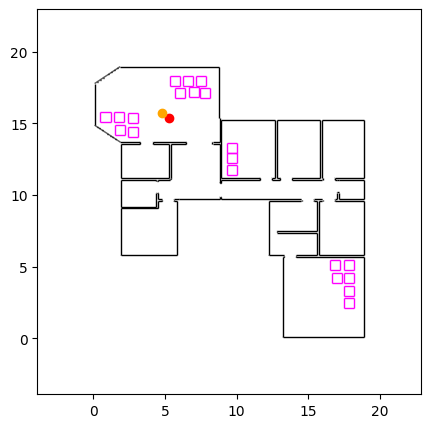

In [236]:
t = 40

p0 = anchored_pose_prior(_ps[t], 1.0, 10)(key)

shape = (25,25,25)
res = (0.1,0.1,0.1)
vs = vector_grid(p0, shape, res, flat=True)
vs.shape



# ---------------------
plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.xlim(np.min(_segs[:,:,0])-padding, np.max(_segs[:,:,0])+padding)
plt.ylim(np.min(_segs[:,:,1])-padding, np.max(_segs[:,:,1])+padding)
plt.gca().add_collection(line_collection(_segs[:,0],_segs[:,1], c="k", zorder=1))
plt.gca().add_collection(line_collection(_boxes[:,0],_boxes[:,1], c="magenta", zorder=1))
plt.scatter(*_ps[t][:2], c="r", zorder=2)
plt.scatter(*p0[:2], c="orange", zorder=2)
plt.scatter(*apply_2dpose(p, xs).T, s=10, zorder=2)


In [235]:
key = more_keys(key)
q = grid_proposal(tr, key, p0, shape, res)(key)

# ---------------------
plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.xlim(np.min(_segs[:,:,0])-padding, np.max(_segs[:,:,0])+padding)
plt.ylim(np.min(_segs[:,:,1])-padding, np.max(_segs[:,:,1])+padding)
plt.gca().add_collection(line_collection(_segs[:,0],_segs[:,1], c="k", zorder=1))
plt.gca().add_collection(line_collection(_boxes[:,0],_boxes[:,1], c="magenta", zorder=1))
plt.scatter(*_ps[t][:2], c="r", zorder=2)
plt.scatter(*q[:2], c="orange", zorder=2)
plt.scatter(*apply_2dpose(p, xs).T, s=10, zorder=2)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[].
dimensions argument of jnp.indices

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [75]:
key = more_keys(key)
%timeit -n 1 -r 1 eval_poses(tr, key, vs).block_until_ready()

78.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [79]:
key = more_keys(key)
ch = choice_map({
        "x":  _xs[t],
        "hd": _hds[t],
        "sig": 0.1,
        "outlier": 0.1,
})

key, (w,tr) = model.importance(key, ch, ())
w

Array(-4.608465, dtype=float32)

In [80]:
key = more_keys(key, 1)
scores = eval_poses(tr, key, vs)
i = jnp.argmax(scores)


ch    = choice_map({'x':vs[i][:2], 'hd':vs[i][2]})
diffs = tuple(map(lambda v: Diff(v, UnknownChange), tr.args))
tr_i = tr.update(key, ch, diffs)[1][2]

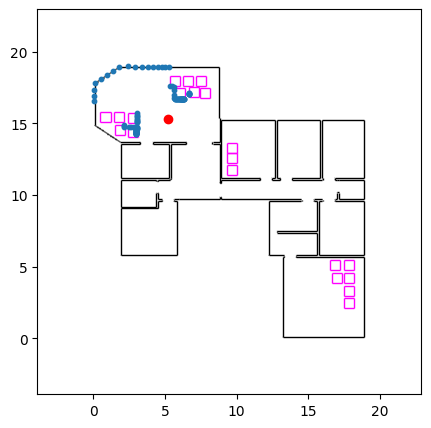

In [82]:
p, xs = tr_i.get_retval()

_segs  = _segs.reshape(-1,2,2)
_boxes = _boxes.reshape(-1,2,2)

# ---------------------
plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
PAD = 4
plt.xlim(np.min(_segs[:,:,0])-PAD, np.max(_segs[:,:,0])+PAD)
plt.ylim(np.min(_segs[:,:,1])-PAD, np.max(_segs[:,:,1])+PAD)
plt.gca().add_collection(line_collection(_segs[:,0],_segs[:,1], c="k", zorder=1))
plt.gca().add_collection(line_collection(_boxes[:,0],_boxes[:,1], c="magenta", zorder=1))
plt.scatter(*p[:2], c="r", zorder=2)
plt.scatter(*apply_2dpose(p, xs).T, s=10, zorder=2)

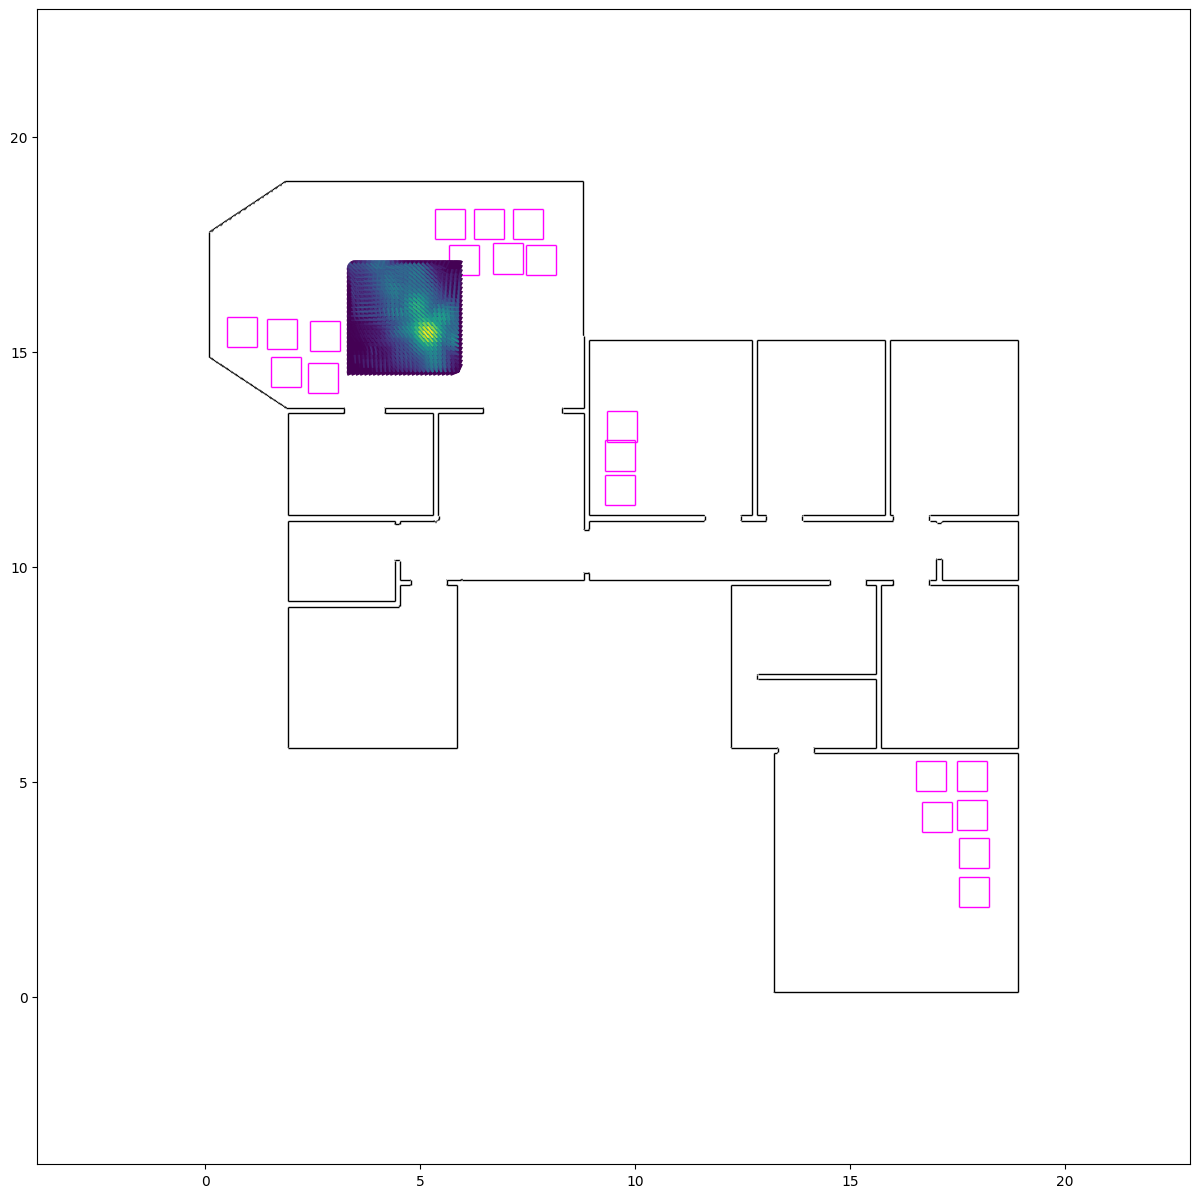

In [225]:
order = jnp.argsort(scores)

sc_ = jnp.clip(scores,jnp.quantile(scores, 0.5), jnp.max(scores))
cs = plt.cm.viridis(plt.Normalize()(sc_))

a = vs[order,:2]
b = a + 0.2*jax.vmap(unit_vec)(vs[order,2])
lines = np.column_stack((a, b)).reshape(-1, 2, 2)
lc = LineCollection(lines, colors=cs[order], linewidths=1)


# -------------------
plt.figure(figsize=(15,15))
plt.gca().set_aspect(1)
PAD = 4
plt.xlim(np.min(_segs[:,:,0])-PAD, np.max(_segs[:,:,0])+PAD)
plt.ylim(np.min(_segs[:,:,1])-PAD, np.max(_segs[:,:,1])+PAD)
plt.gca().add_collection(line_collection(_segs[:,0],_segs[:,1], c="k", zorder=1))
plt.gca().add_collection(line_collection(_boxes[:,0],_boxes[:,1], c="magenta", zorder=1))
plt.gca().add_collection(lc);

In [221]:
sc = eval_poses(tr, key, vs)
order = jnp.argsort(sc) 
sc = sc[order]
sc = sc - jax.scipy.special.logsumexp(sc)


key = more_keys(key)


genjax.tfp_categorical.sample(key, sc)

Array(15624, dtype=int32)

In [213]:
genjax.tfp_categorical.sample(key, jnp.log(jnp.array([0,1])))

Array(1, dtype=int32)

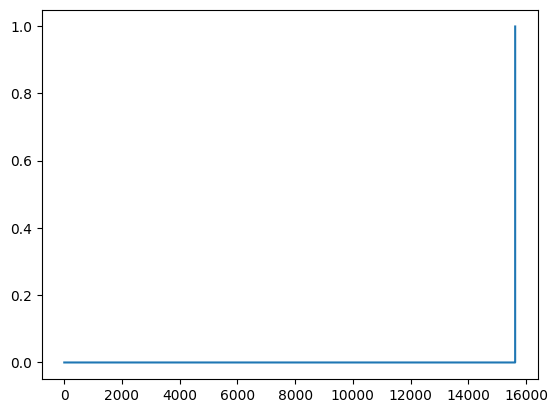

In [154]:
plt.plot(jnp.exp(sc))

In [113]:
genjax.categorical.sample(key, jnp.ones(10)/10)

Array(4, dtype=int32)